# Type B and Type C QPO toy dataset

## Loading dataset

In [1]:
import astropy
from astropy.table import Table
from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum, DynamicalPowerspectrum, Crossspectrum, AveragedCrossspectrum
from astropy.modeling import models, fitting
from stingray.modeling.scripts import fit_powerspectrum, fit_lorentzians, fit_crossspectrum
from scipy.stats import binned_statistic

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
type_b = "./toy_TypeB_lightcurve.fits"
type_c = "./toy_TypeC_lightcurve.fits"

lc_fits = Table.read(type_b)
meta = lc_fits.meta
print(lc_fits.info())
print(meta)
dt = meta['DT']
n_bins = meta['N_BINS']
n_seg = meta['N_SEG']
n_seconds = meta['NSECONDS']
n_chans = meta['DETCHANS']
lc_fits

<Table length=8192>
name  dtype   shape   unit             description           
---- ------- ------- ------ ---------------------------------
 REF float64   (46,) ct / s       Reference band light curves
  CI float64 (5, 46) ct / s Channels of interest light curves
None
OrderedDict([('N_BINS', 8192), ('DT', 0.0078125), ('DETCHANS', 5), ('CHBIN', '/Users/abbie/Documents/GitHub/gsoc18/epoch5_chbinfile.txt'), ('N_SEG', 46), ('NSECONDS', 64.0), ('INFILE', "['st.fits']"), ('OBJECT', 'GX_339-4')])


REF [46],"CI [5,46]"
ct / s,ct / s
float64,float64
256.0 .. 768.0,256.0 .. 0.0
256.0 .. 384.0,256.0 .. 0.0
512.0 .. 640.0,256.0 .. 0.0
640.0 .. 128.0,384.0 .. 0.0
1408.0 .. 384.0,384.0 .. 0.0
768.0 .. 768.0,768.0 .. 128.0
256.0 .. 512.0,512.0 .. 256.0
512.0 .. 128.0,512.0 .. 256.0


In [3]:
# multiply dt to get counts
ref = np.asarray(lc_fits['REF'].T * dt, dtype=np.float64)
ci = np.asarray(lc_fits['CI'].T * dt, dtype=np.float64)
print(ref.shape, ci.shape)

# get counts in ref and ci bands
ref_counts = np.hstack(ref)
ci_counts = np.hstack(ci)
print(ref_counts.shape, ci_counts.shape)

(46, 8192) (46, 5, 8192)
(376832,) (5, 376832)


## Plotting light curve and power spectrum of reference band

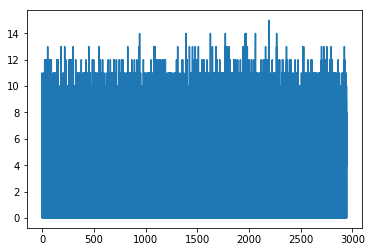

In [4]:
# rearranging reference band segments
ref_counts = np.hstack(ref)
ref_times = np.arange(0, n_seconds*n_seg, dt)

# plotting reference band lightcurve
ref_lc = Lightcurve(ref_times, ref_counts, dt=dt)
ref_lc.plot()

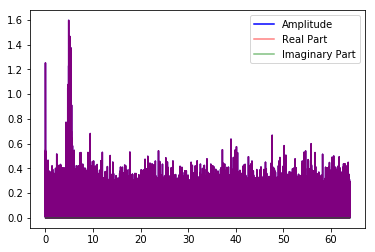

In [5]:
# plotting power spectrum of reference band
ref_ps = Powerspectrum(ref_lc, norm='abs') # absolute normalisation
ref_ps.plot()

## Cross spectrum and averaged cross spectrum of a channel of interest

In [6]:
# CoI light curve
ci_counts_0 = ci_counts[0]
ci_times = np.arange(0, n_seconds*n_seg, dt)
ci_lc = Lightcurve(ci_times, ci_counts_0, dt=dt)

# rebinning factor used in `rebin_log`
rebin_log_factor = 0.04

In [7]:
# CoI cross spectrum
cs = Crossspectrum(lc1=ci_lc, lc2=ref_lc, norm='leahy', amplitude=True)
cs = cs.rebin_log(0.04) # rebinning

In [8]:
# CoI averged cross spectrum
avg_cs = AveragedCrossspectrum(lc2=ci_lc, lc1=ref_lc, segment_size=n_seg, norm='leahy', amplitude=True)
avg_cs = avg_cs.rebin_log(rebin_log_factor) #rebinning
print(len(avg_cs.freq))

122


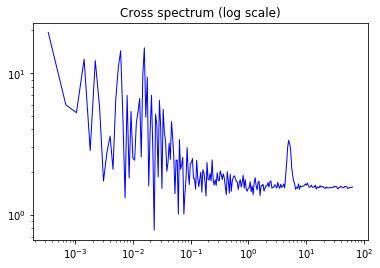

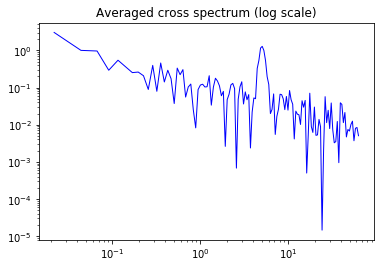

In [9]:
plt.figure()
plt.title("Cross spectrum (log scale)")
plt.loglog(cs.freq, np.abs(cs.power), lw=1, color='blue')

plt.figure()
plt.title("Averaged cross spectrum (log scale)")
plt.loglog(avg_cs.freq, np.abs(avg_cs.power), lw=1, color='blue')

## Fitting the model

In [10]:
# fitting model 
model_to_test = models.Lorentz1D(x_0=5.) + models.PowerLaw1D(amplitude=0.5, x_0=0.08) + models.Const1D(amplitude=0.01)

avg_cs_parest, avg_cs_res = fit_crossspectrum(avg_cs, model_to_test)
avg_cs_res_model = avg_cs_res.model
print(avg_cs_res_model)
print("New parameters:", avg_cs_res_model.parameters)

Model: CompoundModel1
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Lorentz1D(amplitude=1., x_0=5., fwhm=1.)>

    [1]: <PowerLaw1D(amplitude=0.5, x_0=0.08, alpha=1.)>

    [2]: <Const1D(amplitude=0.01)>
Parameters:
       amplitude_0          x_0_0       ...      alpha_1           amplitude_2     
    ----------------- ----------------- ... ------------------ --------------------
    1.378500834039943 5.058409700874344 ... 1.0699936396230751 0.013129429517161378
New parameters: [1.37850083 5.0584097  0.65297258 0.5052323  0.11017691 1.06999364
 0.01312943]


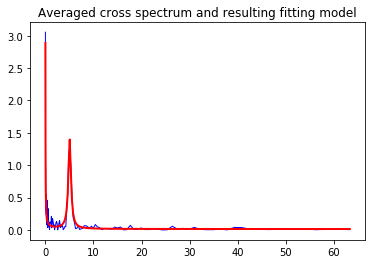

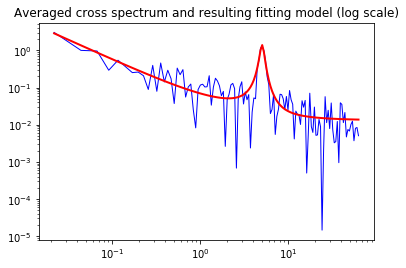

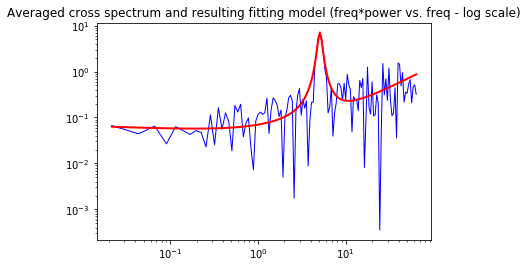

In [11]:
# plotting graphs along with resulting model
plt.figure()
plt.title("Averaged cross spectrum and resulting fitting model")
plt.plot(avg_cs.freq, np.abs(avg_cs.power), lw=1, color='blue')
plt.plot(avg_cs.freq, np.abs(avg_cs_res.mfit), lw=2, color="red")

plt.figure()
plt.title("Averaged cross spectrum and resulting fitting model (log scale)")
plt.loglog(avg_cs.freq, np.abs(avg_cs.power), lw=1, color='blue')
plt.loglog(avg_cs.freq, np.abs(avg_cs_res.mfit), lw=2, color="red")

plt.figure()
plt.title("Averaged cross spectrum and resulting fitting model (freq*power vs. freq - log scale)")
plt.loglog(avg_cs.freq, avg_cs.freq*np.abs(avg_cs.power), lw=1, color='blue')
plt.loglog(avg_cs.freq, avg_cs.freq*np.abs(avg_cs_res.mfit), lw=2, color="red")

### Using filters

In [12]:
# filter classes
class Window1D():
    def __init__(self, model):
        self.model = model
        self.x_0 = model[0].x_0
        self.fwhm = model[0].fwhm

    def __call__(self, x):
        y = np.zeros((len(x),), dtype=np.float64)
        for i in range(len(x)):
            if np.abs(x[i] - self.x_0[0]) <= self.fwhm[0]/2:
                y[i] = 1.
        return y

class Optimal1D():
    def __init__(self, model):
        self.model = model
        qpo_component_model = self.model[0]
        all_components_model = self.model
        self.filter = qpo_component_model / all_components_model

    def __call__(self, x):
        return self.filter(x)

In [13]:
# using optimal filter
optimal_filter = Optimal1D(avg_cs_res_model)
optimal_filter_freq = Optimal1D(avg_cs_res_model)(avg_cs.freq)
filtered_avg_cs_power_o = optimal_filter_freq * np.abs(avg_cs.power)

# using top hat filter
top_hat_filter = Window1D(avg_cs_res_model)
top_hat_filter_freq = Window1D(avg_cs_res_model)(avg_cs.freq)
filtered_avg_cs_power_w = top_hat_filter_freq * np.abs(avg_cs.power)

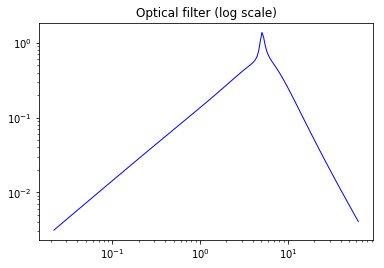

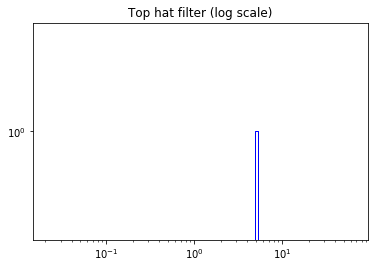

In [14]:
# plotting filters (log scale)
plt.figure()
plt.title("Optical filter (log scale)")
plt.loglog(avg_cs.freq, optimal_filter_freq, lw=1, color='blue')

plt.figure()
plt.title("Top hat filter (log scale)")
plt.loglog(avg_cs.freq, top_hat_filter_freq, lw=1, color='blue')

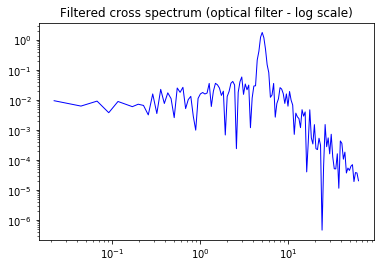

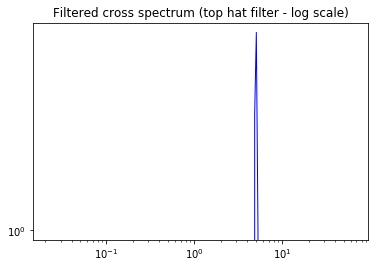

In [15]:
# plotting filtered cross spectrums (log scale)
plt.figure()
plt.title("Filtered cross spectrum (optical filter - log scale)")
plt.loglog(avg_cs.freq, filtered_avg_cs_power_o, lw=1, color='blue')

plt.figure()
plt.title("Filtered cross spectrum (top hat filter - log scale)")
plt.loglog(avg_cs.freq, filtered_avg_cs_power_w, lw=1, color='blue')

## Calculating CCF

In [16]:
from scipy.fftpack import ifft, fft

### Fitting reference band with same model as before
We use this later to calculate rms value used to normalize filtered (avg.) cross spectrum

In [17]:
# function to get new df - description missing
def get_new_df(ps):
    lin_psd, f_bin_edges, something = binned_statistic(ps.freq, ps.power[0:int(ps.n/2+1)], 
                                statistic='mean', bins=1600)
    new_df = np.median(np.diff(f_bin_edges))
    return new_df

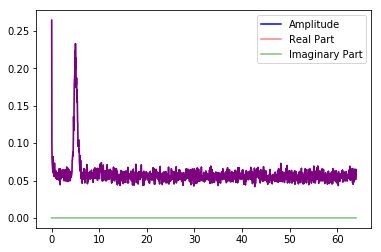

In [18]:
# rebinning power spectrum
new_df = get_new_df(ref_ps)
ref_ps_rebinned = ref_ps.rebin(df=new_df)
ref_ps_rebinned.plot()

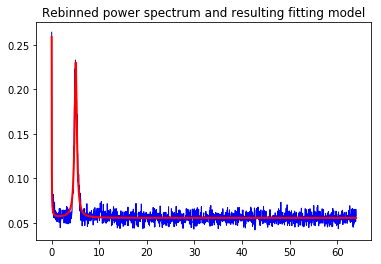

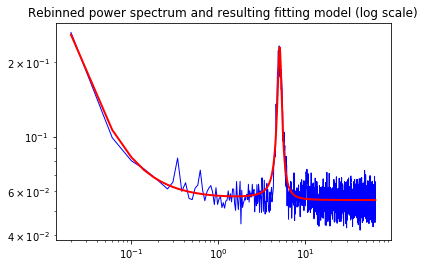

In [19]:
# fitting reference band power spectrum
model_to_test = models.Lorentz1D(x_0=5.) + models.PowerLaw1D(amplitude=0.5) + models.Const1D(amplitude=0.01)
ref_ps_rebinned_parest, ref_ps_rebinned_res = fit_powerspectrum(ref_ps_rebinned, model_to_test)
ref_ps_rebinned_res_model = ref_ps_rebinned_res.model

# plotting graphs along with resulting model
plt.figure()
plt.title("Rebinned power spectrum and resulting fitting model")
plt.plot(ref_ps_rebinned.freq, np.abs(ref_ps_rebinned.power), lw=1, color='blue')
plt.plot(ref_ps_rebinned.freq, np.abs(ref_ps_rebinned_res.mfit), lw=2, color="red")

plt.figure()
plt.title("Rebinned power spectrum and resulting fitting model (log scale)")
plt.loglog(ref_ps_rebinned.freq, np.abs(ref_ps_rebinned.power), lw=1, color='blue')
plt.loglog(ref_ps_rebinned.freq, np.abs(ref_ps_rebinned_res.mfit), lw=2, color="red")

In [20]:
def calculate_rms(ps, model, optimal_filter=False):
    """ function to get fitting model used to calculate rms based on the type of filter used. """
    freq = ps.freq # replace this with self.freq later
    model_output = model(freq)
    if optimal_filter:                              # optimal filter
        for i in range(len(freq)):
            if freq[i] <= 0:
                model_output[i] = 0
    else:                                           # top hat filter
        x_0 = model[0].x_0.value
        fwhm = model[0].fwhm.value
        for i in range(len(freq)):
            if np.abs(freq[i]-x_0) >= (fwhm/2):
                model_output[i] = 0

    df = freq[1]-freq[0]
    rms = np.sqrt(np.sum(model_output * df))

    return rms

### Calculating normalized ccf

1.9280151072297749


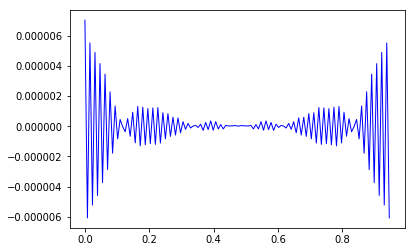

In [21]:
# calculating rms from power spectrum
ref_ps_rebinned_rms_o = calculate_rms(ref_ps_rebinned, ref_ps_rebinned_res_model, optimal_filter=True)
print(ref_ps_rebinned_rms_o)
# calculating normalized ccf
ccf = ifft(filtered_avg_cs_power_o) # inverse fast fourier transformation
ccf_real = ccf.real # real part of ccf
ccf_real_norm_o = ccf_real * (2/n_bins/ref_ps_rebinned_rms_o) # absolute rms-squared normalisation

# plotting ccf
ccf_times = np.arange(0, len(ccf_real_norm_o)*dt, dt) # x-axis
plt.figure()
plt.plot(ccf_times, ccf_real_norm_o, lw=1, color='blue')

### Calculating ccf if top hat filter is used

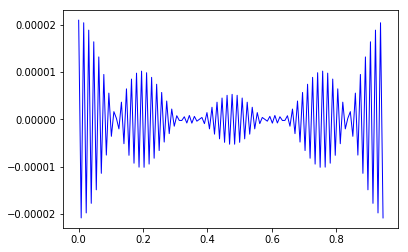

In [22]:
# calculating rms from power spectrum
ref_ps_rebinned_rms_w = calculate_rms(ref_ps_rebinned, ref_ps_rebinned_res_model, optimal_filter=False)

# calculating normalized ccf
ccf = ifft(filtered_avg_cs_power_w) # inverse fast fourier transformation
ccf_real = ccf.real # real part of ccf
ccf_real_norm_w = ccf_real * (2/n_bins/ref_ps_rebinned_rms_w) # absolute rms-squared normalisation

# plotting ccf
ccf_times = np.arange(0, len(ccf_real_norm_w)*dt, dt) # x-axis
plt.figure()
plt.plot(ccf_times, ccf_real_norm_w, lw=1, color='blue')

## Calculating CCF Error

Number of segments: 46
(46, 8192) (46, 8192)


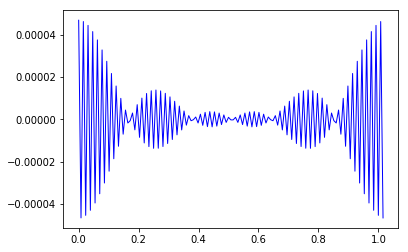

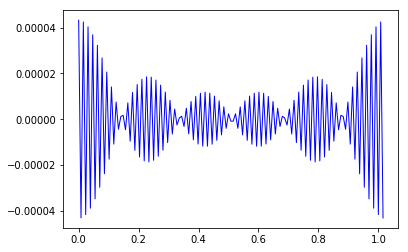

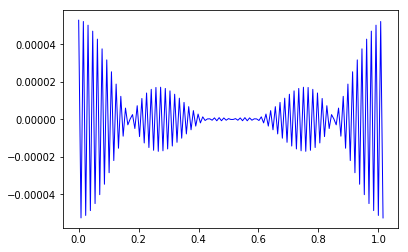

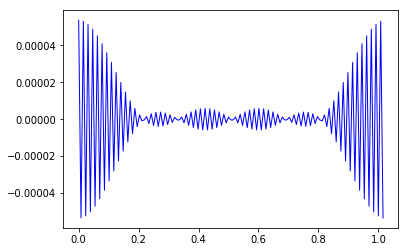

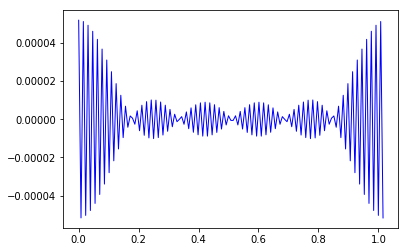

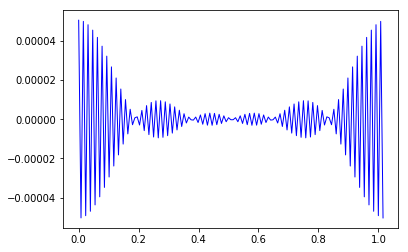

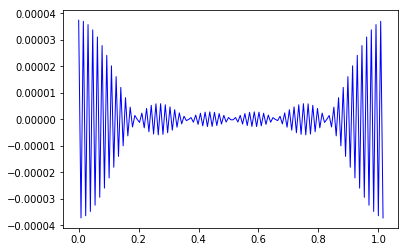

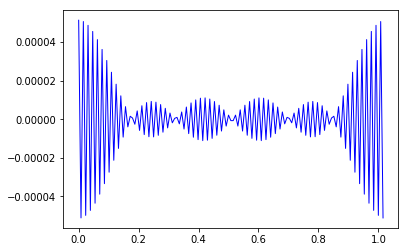

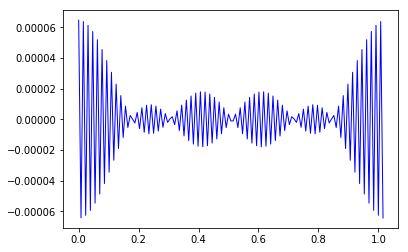

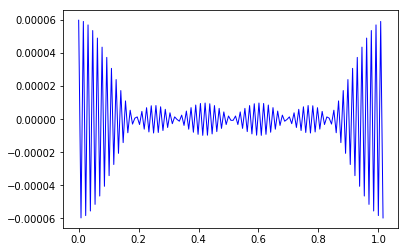

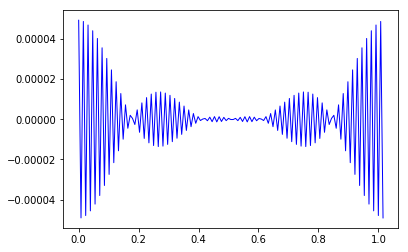

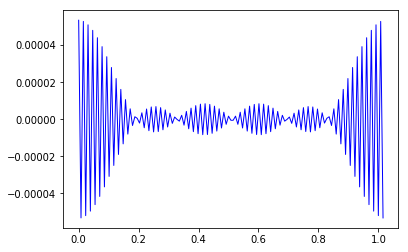

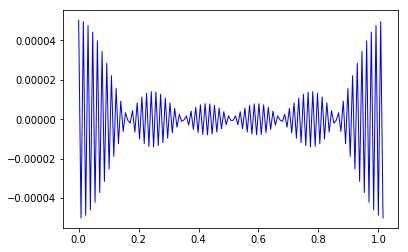

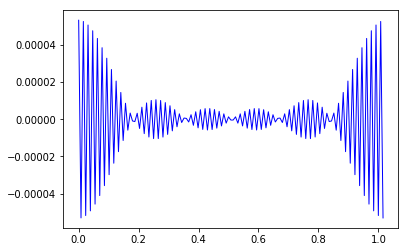

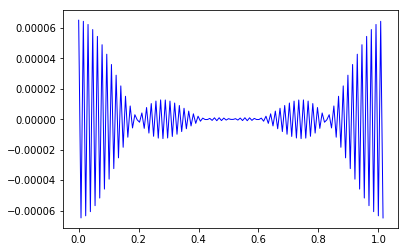

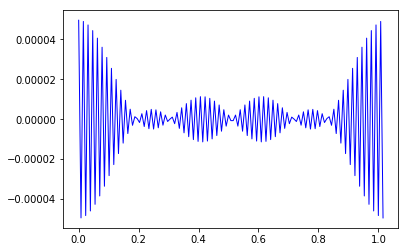

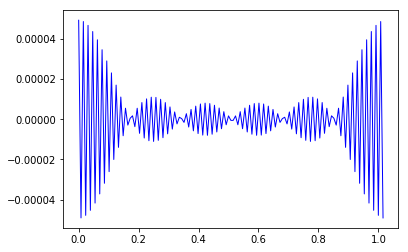

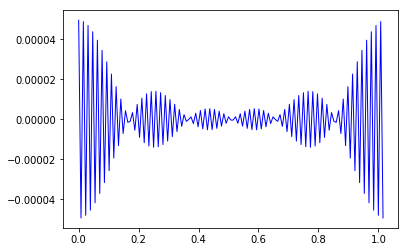

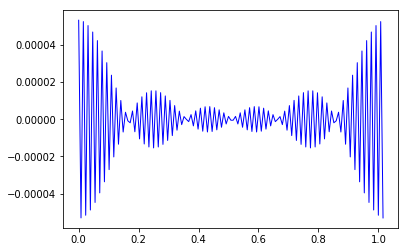

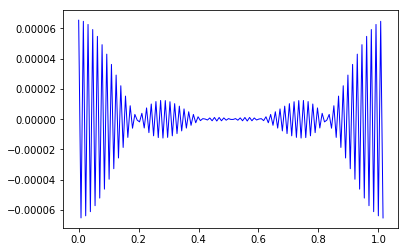

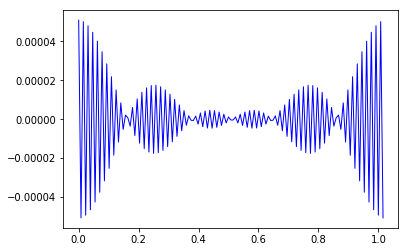

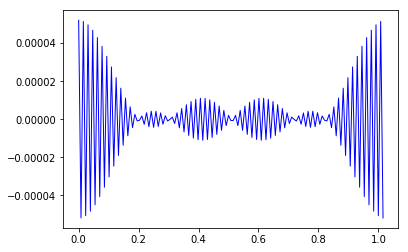

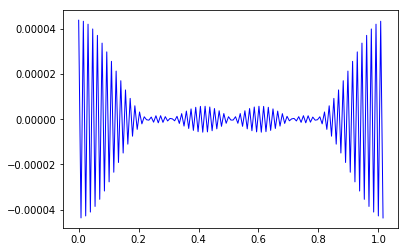

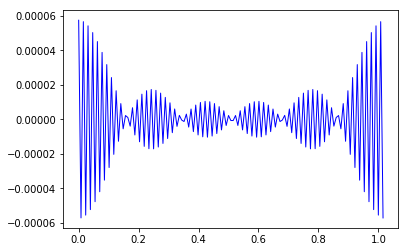

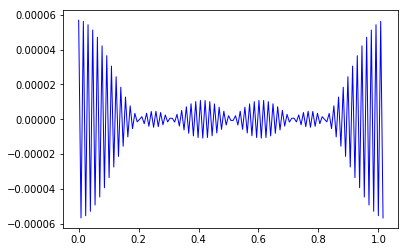

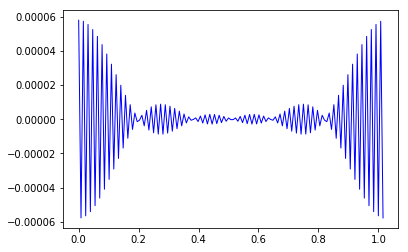

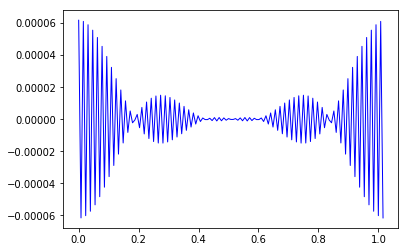

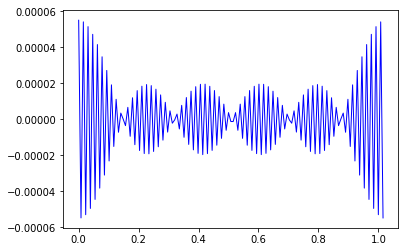

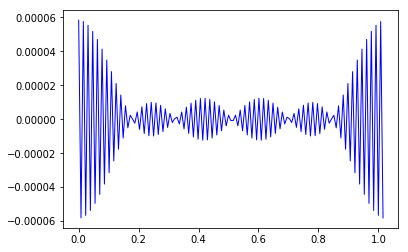

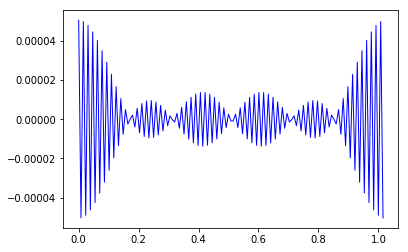

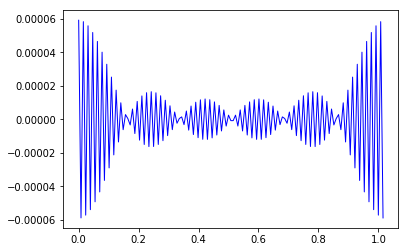

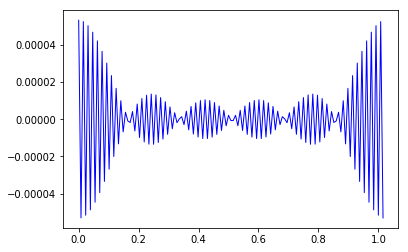

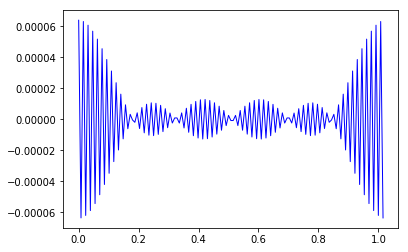

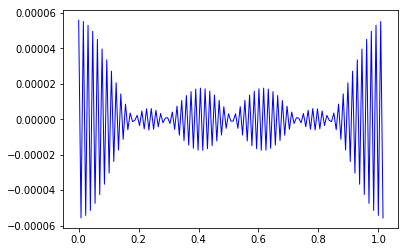

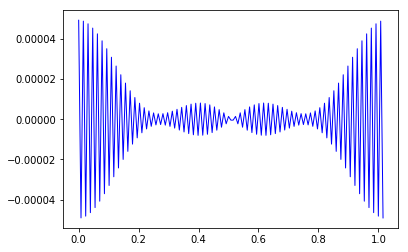

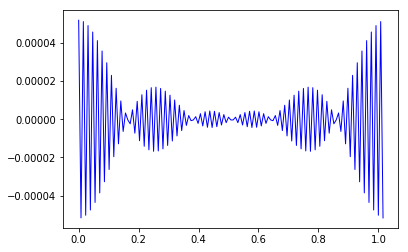

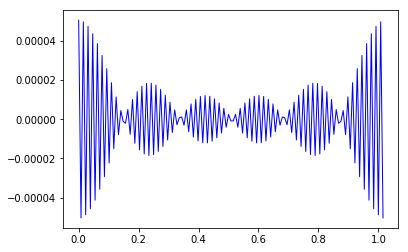

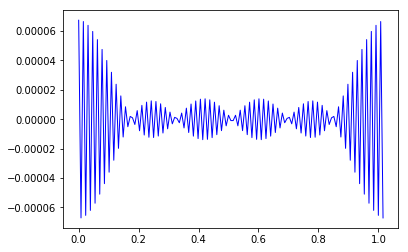

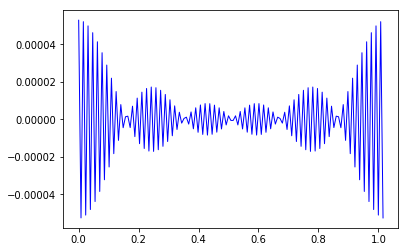

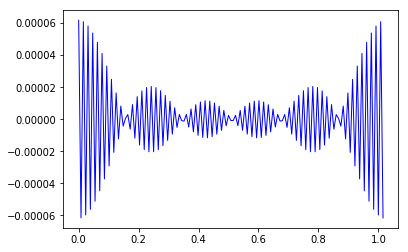

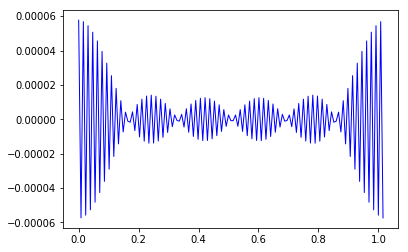

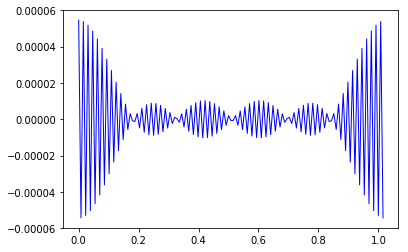

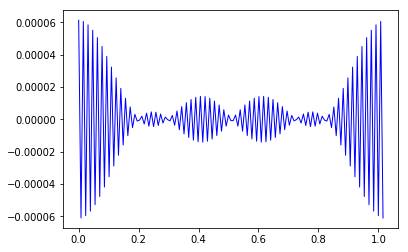

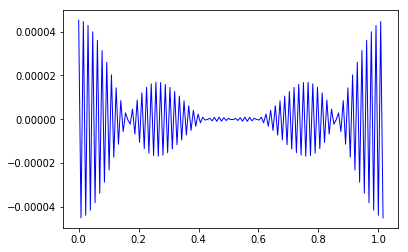

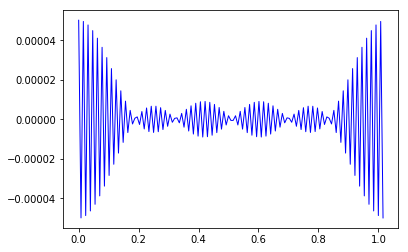

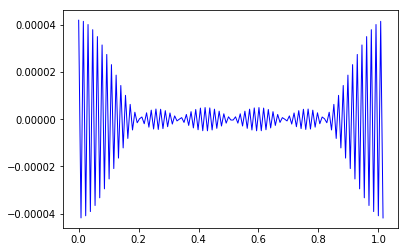

In [23]:
seg_ref_counts = np.array(np.split(ref_counts, n_seg))
seg_ci_counts = np.array(np.split(ci_counts_0, n_seg))
seg_css = np.array([])
seg_ccfs = np.array([])
seg_times = np.arange(0, n_seconds, dt) # light curve time bins

print("Number of segments:", n_seg)
print(seg_ref_counts.shape, seg_ci_counts.shape)

for i in range(n_seg): # for each segment
    # Creating cross spectrum
    seg_ci_lc = Lightcurve(seg_times, seg_ci_counts[i], dt=dt) # CoI light curve
    seg_ref_lc = Lightcurve(seg_times, seg_ref_counts[i], dt=dt) # reference band light curve
    seg_cs = Crossspectrum(lc2=seg_ci_lc, lc1=seg_ref_lc, norm='leahy', amplitude=True) # cross spectrum
    seg_cs = seg_cs.rebin_log(rebin_log_factor) # cross spectrum rebinning
  
    # applying filter
    optimal_filter = Window1D(avg_cs_res_model)
    optimal_filter_freq = optimal_filter(seg_cs.freq)
    filtered_seg_cs_power = optimal_filter_freq * np.abs(seg_cs.power)

    # calculating normalized ccf
    seg_ccf = ifft(filtered_seg_cs_power) # inverse fast fourier transformation
    seg_ccf_real = seg_ccf.real # real part of ccf
    seg_ccf_real_norm = seg_ccf_real * (2/n_bins/ref_ps_rebinned_rms_w) # absolute rms-squared normalisation
    
    ccf_times = np.arange(0, len(seg_ccf_real_norm)*dt, dt) # x-axis
    plt.figure()
    plt.plot(ccf_times, seg_ccf_real_norm, lw=1, color='blue')
    
    if i == 0:
        seg_css = np.hstack((seg_css, np.array(filtered_seg_cs_power)))
    else:
        seg_css = np.vstack((seg_css, np.array(filtered_seg_cs_power)))
    if i == 0:
        seg_ccfs = np.hstack((seg_ccfs, np.array(seg_ccf_real_norm)))
    else:
        seg_ccfs = np.vstack((seg_ccfs, np.array(seg_ccf_real_norm)))
#     if i == 10:
#         break

Length of previous ccf array: 122 Length of this ccf array: 131


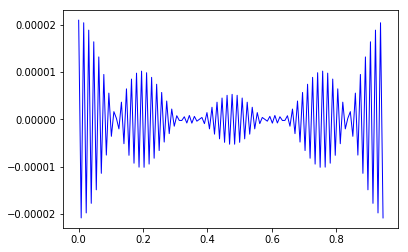

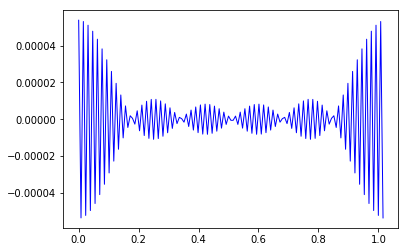

In [24]:
# first one
ccf_times = np.arange(0, len(ccf_real_norm_w)*dt, dt) # x-axis
plt.figure()
plt.plot(ccf_times, ccf_real_norm_w, lw=1, color='blue')

# ccf after taking avg
avg_seg_css = np.average(seg_css, axis=0) # average of all cross spectrums
avg_seg_ccf = ifft(avg_seg_css) # inverse fast fourier transformation
avg_seg_ccf_real = avg_seg_ccf.real # real part of ccf
avg_seg_ccf_real_norm = avg_seg_ccf_real * (2/n_bins/ref_ps_rebinned_rms_w) # absolute rms-squared normalisation

avg_ccf_times = np.arange(0, len(avg_seg_ccf_real_norm)*dt, dt) # x-axis
plt.figure()
plt.plot(avg_ccf_times, avg_seg_ccf_real_norm, lw=1, color='blue')

print("Length of previous ccf array:", len(ccf_real_norm_w), "Length of this ccf array:", len(avg_seg_ccf_real_norm))

### Calculating error

In [25]:
def standard_error(ccf_xs, ccf_mean):
    n_seg = len(ccf_xs)
    
    ccf_xs_diff_sq = np.subtract(ccf_xs, ccf_mean)**2
    standard_deviation = np.sum(ccf_xs_diff_sq, axis=0) / (n_seg-1)
    standard_error = np.sqrt(standard_deviation / n_seg)

    return standard_error

In [26]:
error = standard_error(seg_ccfs, avg_seg_ccf_real_norm)
error

array([9.61982513e-07, 9.59100342e-07, 9.50545977e-07, 9.36596195e-07,
       9.17713284e-07, 8.94545999e-07, 8.67929581e-07, 8.38882799e-07,
       8.08598395e-07, 7.78421006e-07, 7.49804137e-07, 7.24236411e-07,
       7.03130098e-07, 6.87675299e-07, 6.78681657e-07, 6.76448576e-07,
       6.80709209e-07, 6.90672283e-07, 7.05148182e-07, 7.22716598e-07,
       7.41889357e-07, 7.61238990e-07, 7.79484881e-07, 7.95542893e-07,
       8.08549358e-07, 8.17869646e-07, 8.23098659e-07, 8.24057775e-07,
       8.20790500e-07, 8.13557530e-07, 8.02830695e-07, 7.89284108e-07,
       7.73779576e-07, 7.57341913e-07, 7.41118489e-07, 7.26317116e-07,
       7.14118590e-07, 7.05566462e-07, 7.01446803e-07, 7.02181362e-07,
       7.07761575e-07, 7.17742731e-07, 7.31299143e-07, 7.47322318e-07,
       7.64535146e-07, 7.81598421e-07, 7.97196112e-07, 8.10095986e-07,
       8.19188478e-07, 8.23509178e-07, 8.22250149e-07, 8.14764136e-07,
       8.00564418e-07, 7.79321994e-07, 7.50861028e-07, 7.15153045e-07,
      